# <center> A Neural Network Model for Santander-Value

The purpose of this notebook is to build a model (Deep Neural Network) with Tensorflow. We will see the differents steps to do that. This notebook is split in several parts:

- I.    Importation & Devices Available
- II.   Outliers
- III.  Preprocessing
- IV.   DNNRegressor for Contiunuous features
- V.    Predictions
- VI.   Example with Leaky Relu
- VII.  DNNRegressor for Continuous and Categorial
- VIII. Predictions bis
- IX.   Shallow Neural Network
- X.    Conclusion

We will expose 3 models. The first one will use just the continuous features, the second one we will add the categorical features and finally we will use a Neural Network with just one layer.

Theey are no tuning and we will use DNNRegressor with Relu for all activations functions and the number of units by layer are: [200, 100, 50, 25, 12]. So we have 5 layers.

In the part VI I show how to use another activation function with the example of Leaky Relu. Finally I will try to use a Shallow Neural Network (just with one Hidden Layer) just for fun.

If you have an idea to improve the performance of the model: Share it ! Fork it ! And play with it !

# <center> I. Importation & Devices Available

Before the importation I prefer to check the devices available. Sometimes we can have a problems with your GPU for example. And if you want to have a good performance you must do use GPU and not CPU. In our example we have just a CPU but now you have the code to check if your devices is detected.

In [1]:
import os
import tensorflow as tf
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

/Users/longcheng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5688128166119330838]

Now that we have checked the devices available we will test them wth a simple computation. Here we have an example with the computation on the CPU. But you can split the computation on your gpu with '/gpu:0'. If you want more GPU you can do 'with tf.device('/gpu:1'): ', 'with tf.device('/gpu:2'): ' etc...

In our example I display the log information.

In [3]:
# Test with a simple computation
import tensorflow as tf

tf.Session()

with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'):    
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(c))

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

[[22. 28.]
 [49. 64.]]
[node {
  name: "MatMul"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
}
node {
  name: "_retval_MatMul_0_0"
  op: "_Retval"
  input: "MatMul"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
}
library {
}
versions {
  producer: 26
}
]


In this tutorial our data is composed to 1460 row with 81 features. 38 continuous features and 43 categorical features. As exposed in the introduction we will use onlly the continuous features to build our first model.

Here the objective is to predict the House Prices. In this case we have a regression model to build.
So our first data we will contain 37 features to explain the 'Target'. We can see the list of features that we will use to build our first model.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

train = pd.read_csv('../input/train.csv')
print('Shape of the train data with all features:', train.shape)
y_train = train['target']
y_train = np.log1p(y_train)
train.drop("ID", axis = 1, inplace = True)
# train.drop("target", axis = 1, inplace = True)

print("y_train", y_train.shape)
print('Shape of the train data with numerical features:', train.shape)
train.fillna(0,inplace=True)

test = pd.read_csv('../input/test.csv')
# test = test.select_dtypes(exclude=['object'])
# ID = test.Id
ID = test['ID']
test.fillna(0,inplace=True)
test.drop("ID", axis = 1, inplace = True)
print("")
# print("List of features contained our dataset:",list(train.shape))

Shape of the train data with all features: (4459, 4993)
y_train (4459,)
Shape of the train data with numerical features: (4459, 4992)



# <center> II. Outliers

In this small part we will isolate the outliers with an IsolationForest (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). I tried with and without this step and I had a better performance removing these rows.

I haven't analysed the test set but I suppose that our train set looks like more at our data test without these outliers.


In [5]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
y_train = y_train.iloc[y_noano[y_noano['Top'] == 1].index.values]
y_train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 446
Number of rows without outliers: 4013


In [6]:
train.head(5)

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


# <center> III. Preprocessing

To rescale our data we will use the fonction MinMaxScaler of Scikit-learn. I am wondering if it is not interesting to use the same MinMaxScaler for Train and Test !

In [7]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)
print("col_train length:",len(col_train))
print("col_train_bis length:",len(col_train_bis), 'type:',type(col_train_bis))

col_train_bis.remove('target')

# print(col_train_bis)

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
print('mat_test shape', mat_test.shape)
mat_new = np.matrix(train.drop('target',axis = 1))
# mat_y = np.array(train['target']).reshape((1314,1))
y_train_row_count = len(y_train)
print('y_train_row_count:',y_train_row_count)
mat_y = np.array(y_train).reshape((y_train_row_count,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

print("before transform, train",train.shape)
print("before transform, test",test.shape)
train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)
print("after transform, train",train.shape)
print("after transform, test",test.shape)

train.head()

col_train length: 4992
col_train_bis length: 4992 type: <class 'list'>
mat_test shape (49343, 4991)
y_train_row_count: 4013
before transform, train (4013, 4992)
before transform, test (49343, 4991)
after transform, train (4013, 4992)
after transform, test (49343, 4991)


,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.949962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.014261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.249437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.049287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.359520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To use Tensorflow we need to transform our data (features) in a special format. As a reminder we have just the continuous features. So the first function used is: tf.contrib.layers.real_valued_column.
More information here: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column

The others cells allowed to us to create a train set and test set with our training data set.

In [8]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "target"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
print("feature_cols shape:",len(feature_cols))

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = y_train

print("train",train.shape)
print("prediction_set",prediction_set.shape)
print("prediction_set",prediction_set.shape)
print("training_set]",training_set.shape)
print("training_set[FEATURES]",training_set[FEATURES].shape)

# Train and Test 
# TODO: Found input variables with inconsistent numbers of samples: [4013, 2688]
# x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(train, prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

feature_cols shape: 4991
train (4013, 4992)
prediction_set (4013,)
prediction_set (4013,)
training_set] (4013, 4992)
training_set[FEATURES] (4013, 4991)


In [9]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466,target
3878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.369225
2318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.081543
2716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.624351
1288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.912121
3142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.899222


# <center> IV. Deep Neural Network for continuous features

With tf.contrib.learn it is very easy to implement a Deep Neural Network. In our example we will have 5 hidden layers with repsectly 200, 100, 50, 25 and 12 units and the function of activation will be Relu.

The optimizer used in our case is an Adagrad optimizer (by default).

In [10]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [11]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [12]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [13]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1a3d2afe10>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='48df886f9', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0deb4b6a8', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='34b15f335', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='a8cb14b00', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='2f0771a37', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='30347e683', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='d08d1fbe3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='

In [14]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [15]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 8.275632


In [16]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))


# <center> V. Predictions and submission

Let's go to prepare our first submission ! Data Preprocessed: checked ! Outlier excluded: checked ! Model built: : checked! Next step: Used our model to make the predictions with the data set Test. And add one graphic to see the difference between the reality and the predictions.

In [18]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(len(predictions),1)),columns = ['Prediction'])

In [20]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).target

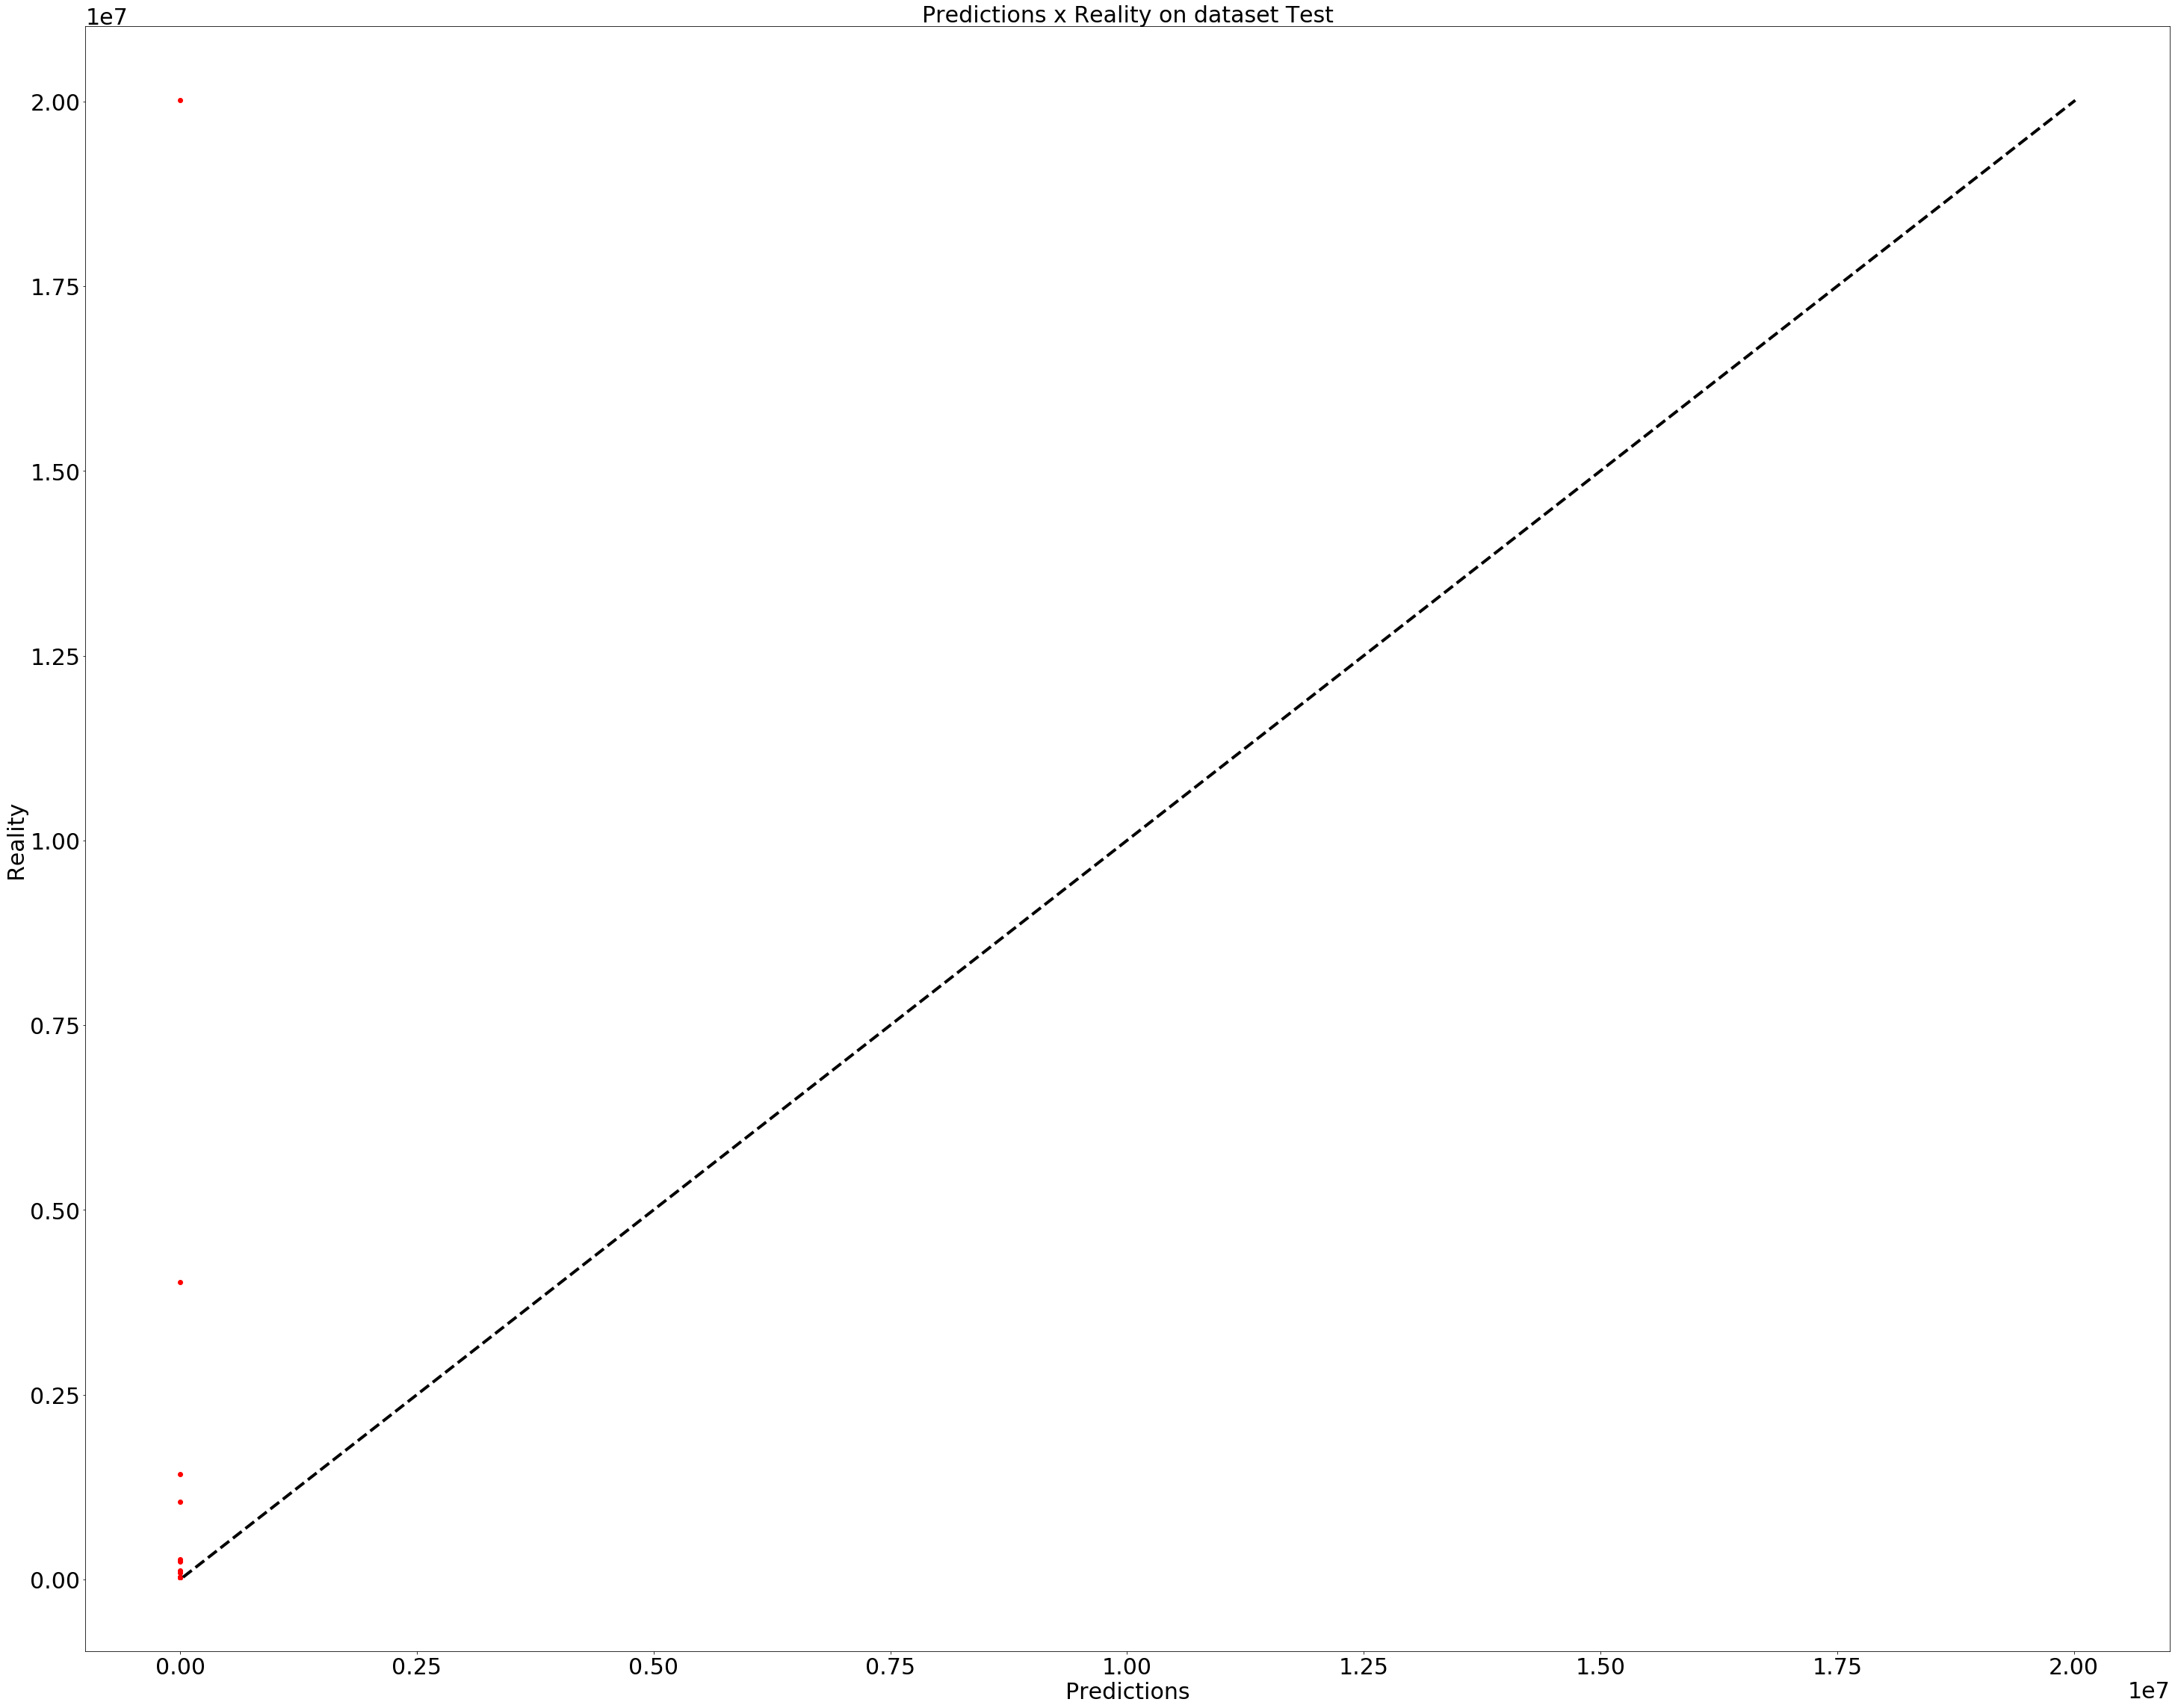

In [21]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [22]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['Target'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

# <center> VI. Leaky Relu

An example with another activation function: Leaky Relu ! We can create this new function with Relu. As a reminder Relu is Max(x,0) and Leaky Relu is the function Max(x, delta*x). In our case we can take delta = 0.01

In [23]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [24]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [25]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

Final Loss on the testing set with Leaky Relu: 9.907468


In [26]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Leaky_relu")

In [27]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

In [28]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

Final Loss on the testing set with Elu: 16.702955


In [29]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Elu")

So we have 3 submissions with 3 differents activation functions. But we built ours models just with the continuous features. If you want to comapare the performance download the 3 submissions and submit to the leaderboard. 
Now we see how do build another model by adding a categorical features.

# <center> VII. Deep Neural Network for continuous and categorical features

For this part I repeat the same functions that you can find previously by adding a categorical features.


In [33]:
# Import and split
train = pd.read_csv('../input/train.csv')
train.drop('ID',axis = 1, inplace = True)
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 

test = pd.read_csv('../input/test.csv')
ID = test.ID
test.drop('ID',axis = 1, inplace = True)
test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

In [34]:
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

In [39]:
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('target')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('target',axis = 1))
mat_y = np.array(train.target)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(len(mat_y),1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

In [40]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

The principal changements are here with the lines beginning by for categorical_features... It is possible to use other function to prepare your categorical data. 

In [42]:
# List of features
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "target"

FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.target

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)

# Training for submission
training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]

In [43]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True)

In [44]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)

def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

In [45]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}

In [46]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c0b37c2b0>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='48df886f9', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0deb4b6a8', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='34b15f335', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='a8cb14b00', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='2f0771a37', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='30347e683', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='d08d1fbe3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='

In [47]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

In [48]:
loss_score4 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score4))

Final Loss on the testing set: 0.044067


# <center> VIII. Predictions bis

In [49]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(len(predictions),1)))

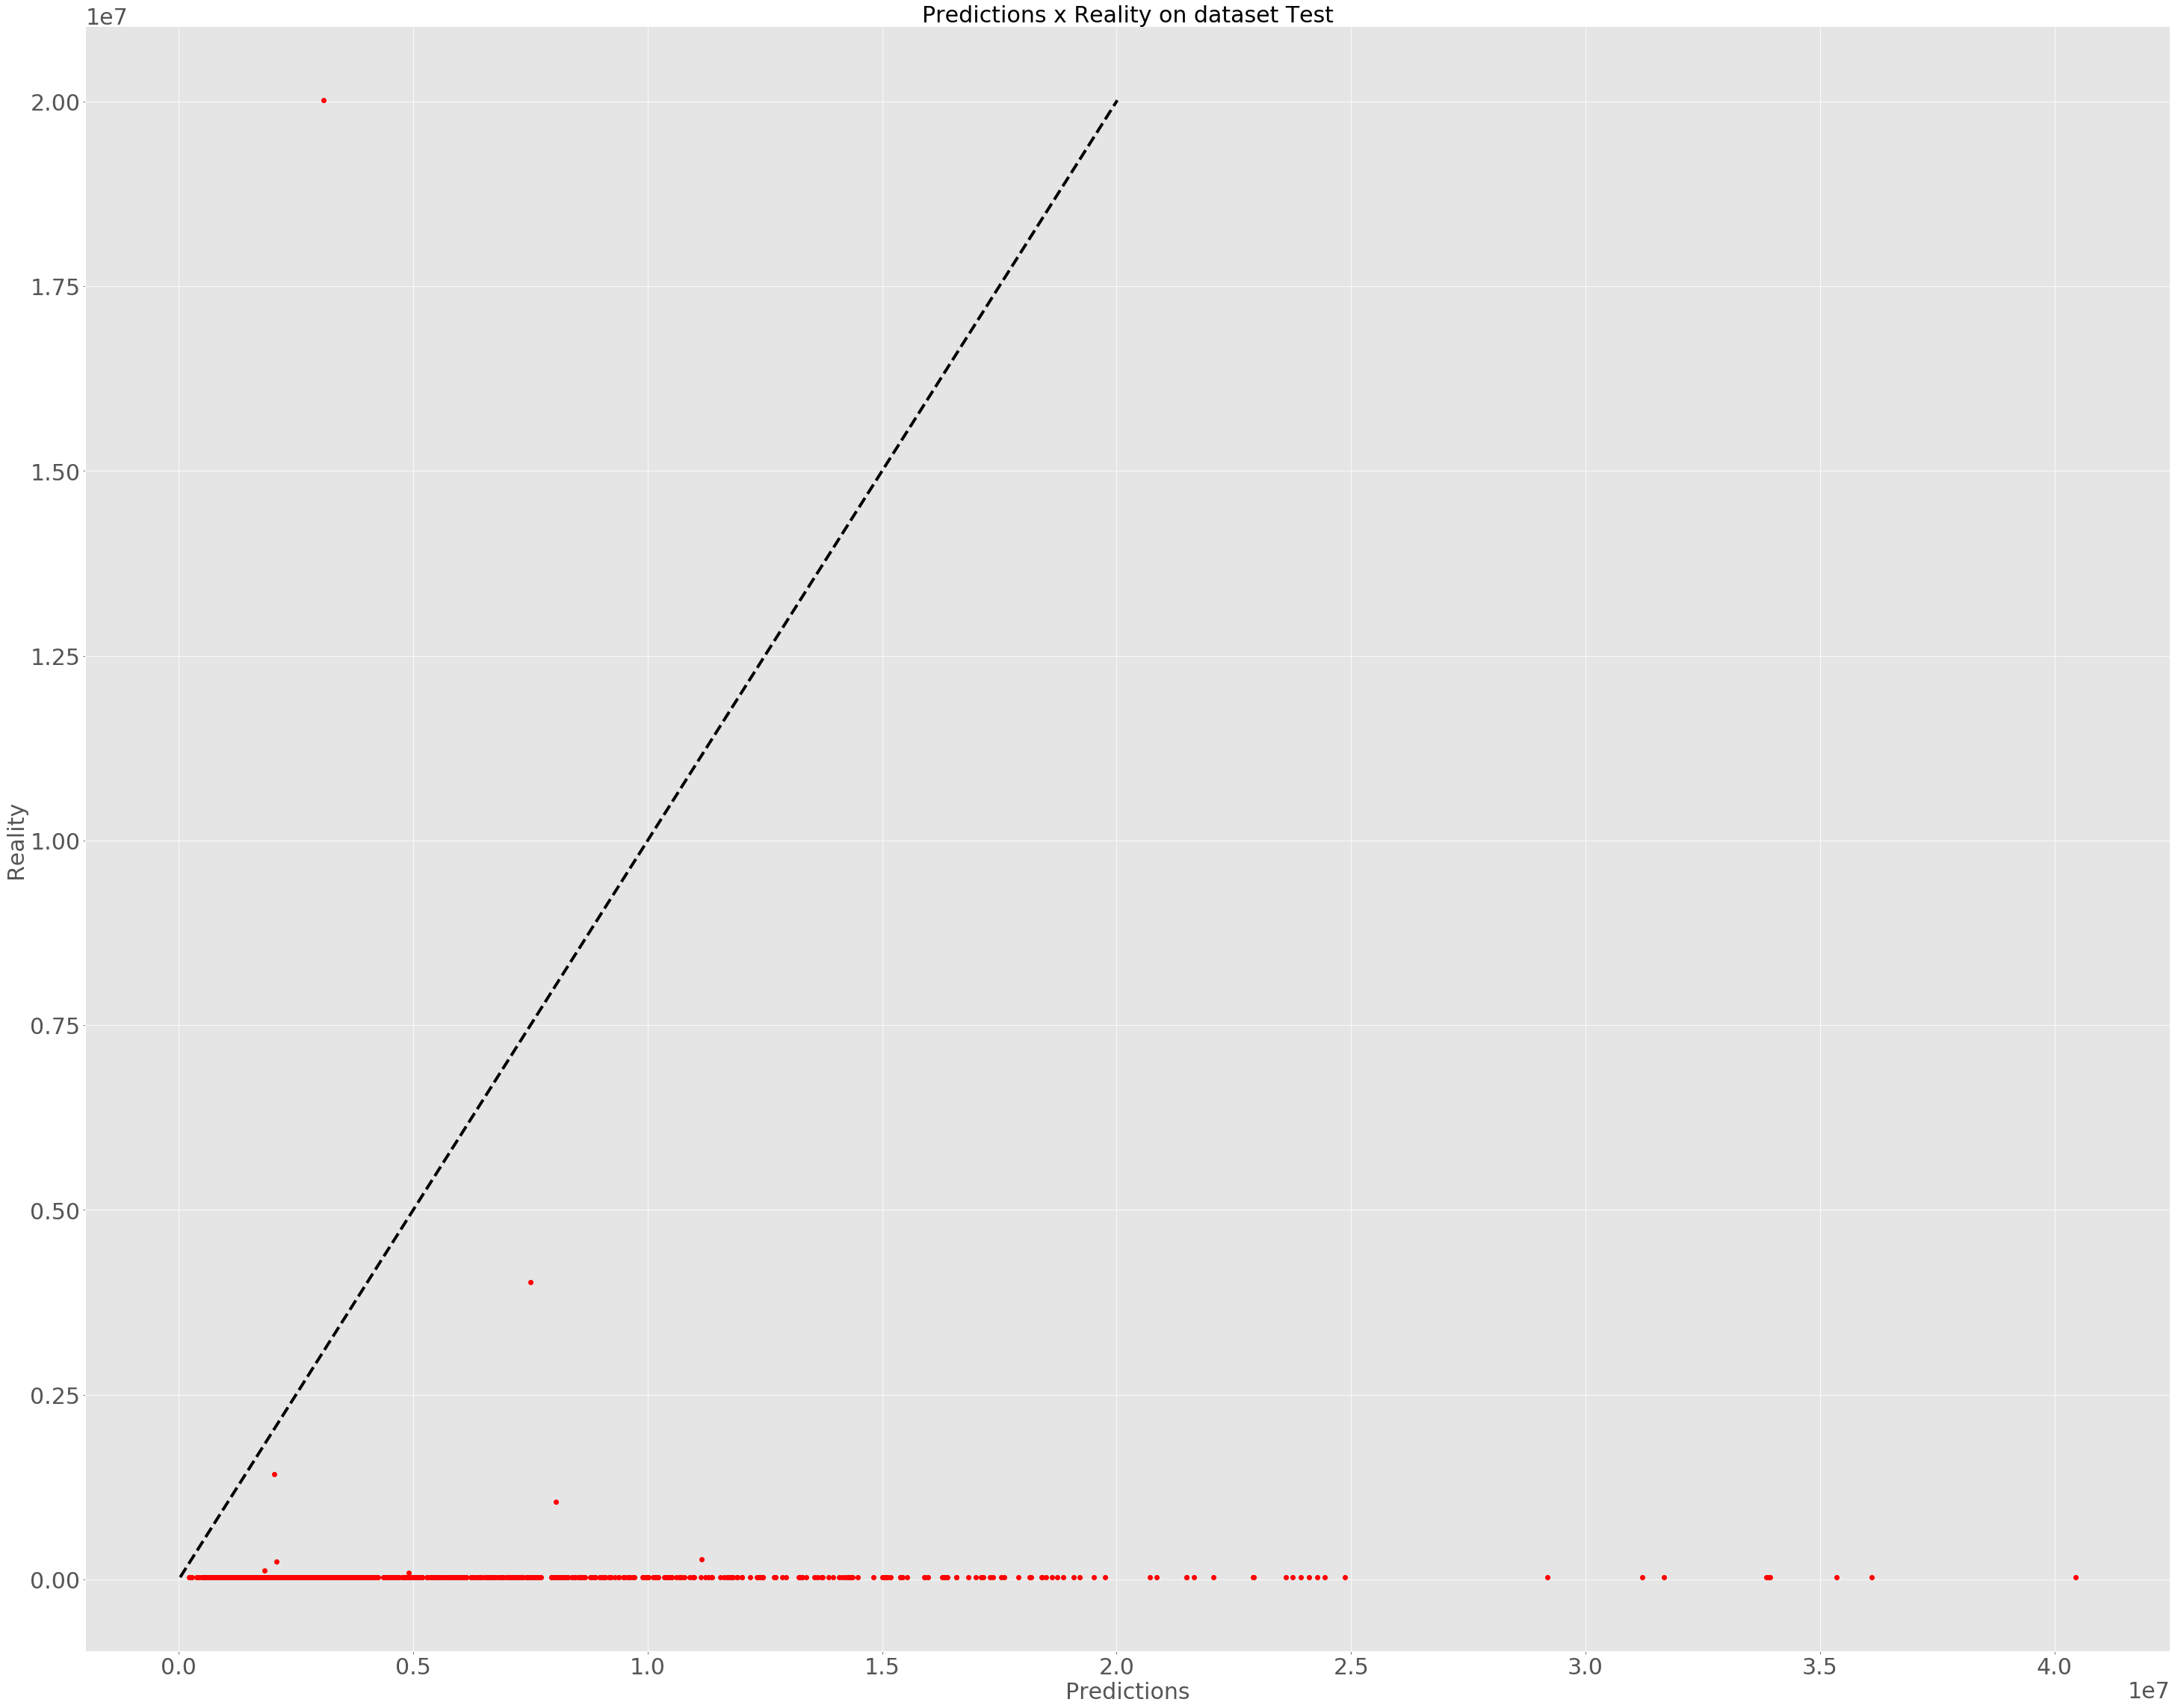

In [50]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [51]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))

In [52]:
to_submit(y_predict, "submission_cont_categ")

# <center> IX. Shallow Network

For this part we will expolore the architecture with just one Hidden Layer with several units. The question is: How many units do you need to have a good score on the leaderboard? We will try with 1000 units with the activation function Relu.

In [53]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000])

In [54]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c0b469ef0>, 'hidden_units': [1000], 'feature_columns': (_RealValuedColumn(column_name='48df886f9', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0deb4b6a8', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='34b15f335', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='a8cb14b00', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='2f0771a37', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='30347e683', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='d08d1fbe3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='6ee66e115', dime

In [55]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [56]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

Final Loss on the testing set: 0.038382


In [57]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    
to_submit(y_predict, "submission_shallow")

# <center> X. Conclusion

In [58]:
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5]
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku']

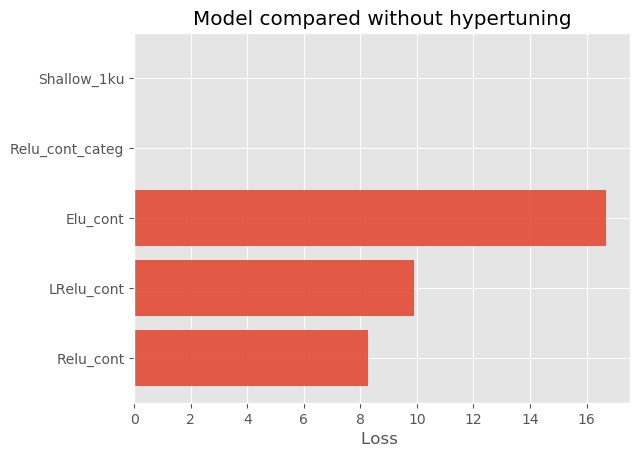

In [59]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9)
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()

So, I hope that this small introduction will be useful ! With this code you can build a regression model with Tensorflow with continuous and categorical features plus add a new activation function (LeakyRelu). 
If you want to improve the results you can re-build the models on the whole of data. You can see that I'm used just 67% of the training set to build my models.

Take my code and play with it: More Hyperparameters, 100% of the training set to build the next models, try with other activation function etc...
